## Energy dependent transmission

We will make a simple simulation under to recover the total neutron cross section from the transmission in a slab:

In [1]:
import openmc
import numpy as np
import matplotlib.pyplot as plt
openmc.config['cross_sections'] = '/home/student/openmc_ncrystal_vm/endfb-viii.0-hdf5/cross_sections.xml'

We start defining a function that returns an OpenMC model for a pencil beam incident perpendicular an slab, with two small spheres to tally the incident and transmitted spectra. The function takes as a parameter an OpenMC material to fill the slab.

In [2]:
def create_model(slab_mat, NParticles=1000000, slab_thickness=1):
    p1 = openmc.ZPlane(z0=-slab_thickness/2)
    p2 = openmc.ZPlane(z0=+slab_thickness/2)
    s1 = openmc.Sphere(r=0.1, z0=-(slab_thickness/2+10))
    s2 = openmc.Sphere(r=0.1, z0=+(slab_thickness/2+10))
    s3 = openmc.Sphere(r=100, boundary_type='vacuum')
    c1 = openmc.Cell(region=+p1&-p2&-s3, fill=slab_mat)
    c2 = openmc.Cell(region=-s1, fill=None)
    c3 = openmc.Cell(region=-s2, fill=None)
    c4 = openmc.Cell(region=(-p1|+p2)&+s1&+s2&-s3, fill=None)
    u1 = openmc.Universe(cells=[c1, c2, c3, c4])
    geometry = openmc.Geometry(root=u1)
    
    source = openmc.Source()
    source.space  = openmc.stats.Point(xyz=[0,0,-(slab_thickness/2+20)])
    source.angle  = openmc.stats.Monodirectional(reference_uvw=[0,0,1])
    source.energy = openmc.stats.Uniform(1e-4,1)
    
    settings = openmc.Settings()
    settings.source = source
    settings.run_mode = 'fixed source'
    settings.batches = 10
    settings.particles = NParticles
    settings.temperature = {'method':'nearest', 'tolerance':1000}

    tally1 = openmc.Tally()
    filter1 = openmc.CellFilter([c2])
    filter2 = openmc.EnergyFilter(np.geomspace(1e-4, 1, 120))
    tally1.scores = ['flux']
    tally1.name = 'incident spectrum'
    tally1.filters = [filter1, filter2]

    tally2 = openmc.Tally()
    filter3 = openmc.CellFilter([c3])
    tally2.scores = ['flux']
    tally2.name = 'transmitted spectrum'
    tally2.filters = [filter2, filter3]

    tallies = openmc.Tallies([tally1, tally2])
    
    return openmc.model.Model(geometry=geometry, settings=settings, tallies=tallies)

We will define a pair of functions to extract the spectra from the statepoint file:

In [3]:
def get_incident_tally(spfile='statepoint.10.h5'):
    with openmc.StatePoint(spfile) as sp:
        tally = sp.get_tally(name='incident spectrum')
        df = tally.get_pandas_dataframe()
        phi_g = df['mean'].values
        E_g = df['energy high [eV]'].values
        return E_g, phi_g

def get_transmitted_tally(spfile='statepoint.10.h5'):
    with openmc.StatePoint(spfile) as sp:
        tally = sp.get_tally(name='transmitted spectrum')
        df = tally.get_pandas_dataframe()
        phi_g = df['mean'].values
        E_g = df['energy high [eV]'].values
        return E_g, phi_g

We can now apply this to the calculation of the transmission in different materials:

In [4]:
dx = 0.2 # cm
m1 = openmc.Material()
m1.add_elements_from_formula('CH2')
m1.set_density('g/cm3', 0.92)
m1.add_s_alpha_beta('c_H_in_CH2')

model = create_model(m1, slab_thickness=dx)
model.export_to_xml()

In [5]:
!rm summary.h5 statepoint.10.h5
openmc.run(output=True)

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

In [6]:
E1, phi1 = get_incident_tally('statepoint.10.h5')
E2, phi2 = get_transmitted_tally('statepoint.10.h5')

We can compare the results of the transmission simulation with the macroscopic total cross section for the material:

In [7]:
E, xs = openmc.calculate_cexs(m1, ['total'])

Text(0, 0.5, 'Macro XS [cm^-1]')

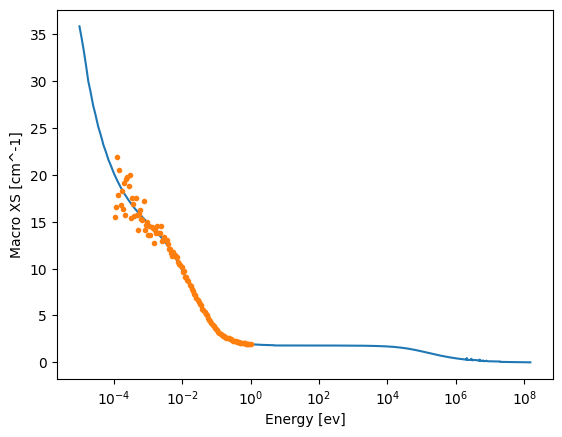

In [8]:
plt.semilogx(E, xs[0])
plt.semilogx(E1,-1/dx*np.log(phi2/phi1), '.')
plt.xlabel('Energy [ev]')
plt.ylabel('Macro XS [cm^-1]')